In [1]:
## NN Model predictor for the data generated in Practical 1
# Here I build a model for predicting the circle equation from the generated data in Practical 1

In [2]:
# Imports
import torch
import torch.nn as nn
import sqlite3

import matplotlib.pyplot as plt

In [3]:
# Set CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Data import
def get_data(path):
    # Takes x_tilde and y_tilde from practical_1.db and returns them as GPU tensors
    db = sqlite3.connect(path)

    cursor = db.execute('''
    SELECT * FROM COORDINATES
    ''')

    x = []
    y = []

    for row in cursor:
        x.append(row[3])
        y.append(row[4])

    x = torch.tensor(x).to(device)
    y = torch.tensor(y).to(device)
    
    return x, y
    
x_dat, y_dat = get_data('Practical_1.db')

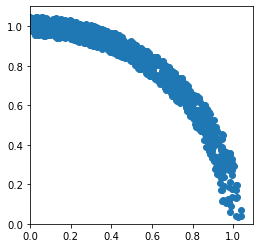

In [5]:
plt.figure(figsize=(4,4))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.scatter(x_dat.cpu().numpy(), y_dat.cpu().numpy())

Sizes:
x:(1000, 1)
y:(1000, 1)


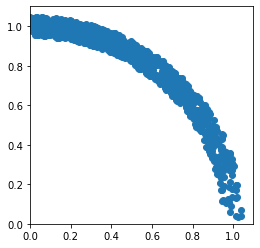

In [6]:
idx = torch.randperm(list(x_dat.size())[0])
x_shuffled = torch.unsqueeze(x_dat.view(-1)[idx].view(x_dat.size()), dim=1)
y_shuffled = torch.unsqueeze(y_dat.view(-1)[idx].view(y_dat.size()), dim=1)

plt.figure(figsize=(4,4))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.scatter(x_shuffled.cpu().numpy(), y_shuffled.cpu().numpy())

print ("Sizes:")
print (f"x:{tuple(x_shuffled.size())}")
print (f"y:{tuple(y_shuffled.size())}")

In [7]:
m = len(x_dat)
train_size = int(m*0.90)
test_size = int(m*0.05)
val_size = test_size

train_x = x_shuffled[0:train_size]
train_y = y_shuffled[0:train_size]

test_x = x_shuffled[train_size:train_size+test_size]
test_y = y_shuffled[train_size:train_size+test_size]

val_x = x_shuffled[train_size+test_size:]
val_y = y_shuffled[train_size+test_size:]

In [8]:
## Defining the model

model = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100, 1)
)
model.to(device)

LR = 0.001
lambda_l2 = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay = lambda_l2)

In [9]:
## Training

model.train()
for i in range(train_size):
    y_pred = model(train_x[i])
    
    loss = criterion(y_pred, train_y[i])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print ("Loss: ", loss.item())
    
print ("Training Done.")

Loss:  0.7310742735862732
Loss:  0.030249174684286118
Loss:  0.006743449717760086
Loss:  2.2218673620955087e-06
Loss:  0.02104056254029274
Loss:  0.0003479713050182909
Loss:  0.0003955982974730432
Loss:  0.00185729144141078
Loss:  0.0006005660980008543
Training Done.


In [10]:
## Val set evaluation

model.eval()
test_loss = 0
for j in range(val_size):
    with torch.no_grad():
        y_pred = model(val_x[j])
        test_loss += criterion(y_pred, val_y[j]).item()
    
test_loss /= test_size
print (test_loss)

0.003498821948469413


In [11]:
## Test set prediction
y_pred = torch.zeros(test_size)
for k in range(test_size):
    with torch.no_grad():    
        y_pred[k] = (model(test_x[k]))

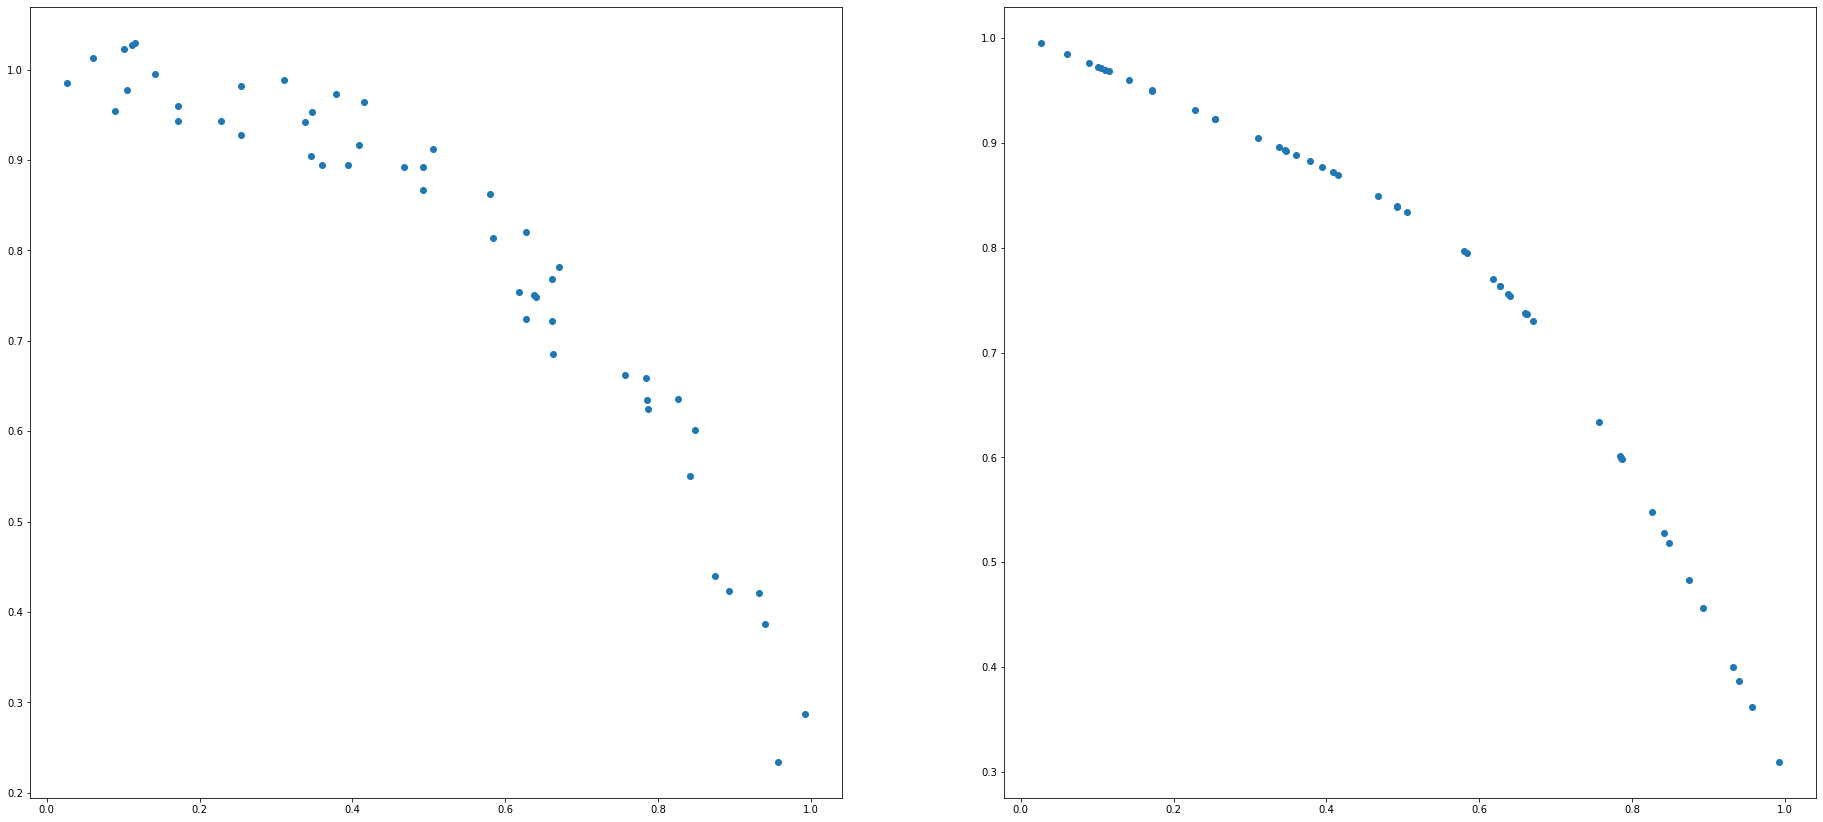

In [12]:
plt.figure(figsize=(32,32))
plt.subplot(2,2,1)
plt.scatter(test_x.cpu().numpy(), test_y.cpu().numpy())

plt.subplot(2,2,2)
plt.scatter(test_x.cpu().numpy(), y_pred.cpu().numpy())